#### 数据特征重要性选择
0. 数据加载处理
1. 降维
2. xgboost选择重要性
3. 去除重要性，比较
4. 新增派生特征
5. 算法改进，比较

##### 0. 数据加载处理

In [1]:
!ls /work/datasets/

ddos_balanced.7z    train_triplets.txt.zip
ddos_imbalanced.7z  unbalaced_20_80_dataset.csv
final_dataset.csv   unbalaced_test.csv
fin.csv		    yelp_academic_dataset_business.json.zip


In [110]:
import numpy as np
import pandas as pd


def get_orgrin_data(file_path):
    return pd.read_csv(file_path, low_memory=False)


def get_data_set(file_path):

    ddos_data = pd.read_csv(file_path, low_memory=False)
    # 暂时剔除无意义的特征
    del ddos_data['Row']
    # 删除非数值列
    other_data = ddos_data.drop([
        'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
        'Timestamp'
    ],
                                axis=1)
    # 删除空值
    other_data = other_data.dropna(how='all')
    # 转换为numpy  aarray
    new_data = other_data.to_numpy()
    # 拆分特征列和目标列
    X, y = new_data[:, :-1], new_data[:, -1]
    # 数值型转换类型
    X = X.astype(float)
    # 处理nan or inf
    X = np.nan_to_num(X)
    return X, y

In [3]:
file = "/work/datasets/fin.csv"
X,y = get_data_set(file)

In [4]:
X[0],y[0]

(array([ 3.97486200e+06,  2.90000000e+01,  4.40000000e+01,  8.60000000e+01,
         5.98110000e+04,  8.60000000e+01,  0.00000000e+00,  2.96551724e+00,
         1.59697991e+01,  1.46000000e+03,  0.00000000e+00,  1.35934091e+03,
         3.72027190e+02,  1.50689508e+04,  1.83654175e+01,  5.52064167e+04,
         1.95478317e+05,  1.56682100e+06,  1.67000000e+02,  3.73534700e+06,
         1.33405250e+05,  3.41775689e+05,  1.80501500e+06,  1.67000000e+02,
         3.97486200e+06,  9.24386512e+04,  2.48174821e+05,  1.56682100e+06,
         3.99700000e+03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  7.68000000e+02,  8.96000000e+02,  7.29585077e+00,
         1.10695667e+01,  0.00000000e+00,  1.46000000e+03,  8.09418919e+02,
         7.28862428e+02,  5.31240439e+05,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  8.20506849e+02,
         2.9

In [5]:
# 基本数据特征处理
def max_min_sc(X):
    # 特征归一化处理
    from sklearn.preprocessing import MinMaxScaler
    min_max_scaler = MinMaxScaler()
    return min_max_scaler.fit_transform(X)


def label_encoder(y):
    # 标签数值化，方便处理
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    return le.fit_transform(y)

In [6]:
y = label_encoder(y)
X = max_min_sc(X)
X[0],y[0]

/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(array([3.31240929e-002, 3.44745602e-003, 2.73955544e-003, 3.24112459e-003,
        2.71063923e-003, 2.65350201e-002, 0.00000000e+000, 2.01667272e-003,
        1.34977744e-002, 3.25239474e-001, 0.00000000e+000, 6.43178996e-001,
        1.84628878e-001, 8.38238214e-305, 1.02068297e-307, 4.60137547e-004,
        2.63561188e-003, 1.30592278e-002, 1.39192099e-006, 3.11288629e-002,
        1.23900737e-003, 4.74153524e-003, 1.67140414e-002, 1.55102014e-006,
        3.31241995e-002, 9.92798499e-004, 3.32219493e-003, 1.45121220e-002,
        4.29280993e-005, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 4.39098019e-003, 2.78922661e-003, 2.43195026e-006,
        5.53478335e-006, 0.00000000e+000, 3.25239474e-001, 5.38984139e-001,
        4.87198333e-001, 2.37362216e-001, 0.00000000e+000, 1.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 1.11111111e-001, 5.45675003e-001,
        2.01

In [7]:
def split_X_y(X, y):
    # 拆分数据集
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=2019)
    return X_train, X_test, y_train, y_test


def classify_re(y_test, y_pred):
    #准确率
    from sklearn.metrics import classification_report
    return classification_report(y_test, y_pred)

##### 1.降维处理

In [8]:
X.shape

(19999, 76)

In [9]:
76*0.6

45.6

In [10]:
def pca_data(X, n_components=45, random_state=2019):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=n_components,
              copy=True,
              whiten=False,
              svd_solver='auto',
              tol=0.0,
              iterated_power='auto',
              random_state=random_state)
    return pca.fit_transform(
        X), pca.explained_variance_ratio_, pca.singular_values_

- https://www.zhihu.com/question/38417101
- pca.explained_variance_ratio_(方差贡献占比)
- pca.explained_variance_(方差贡献绝对值)
- PCA是将n维特征映射到k维上（k<n），这k维特征是全新的正交特征，称为主元，是重新构造出来的k维特征，
- 而不是简单的从n维特征中去除其余n-k维特征。
- 降维后的结果是原来数据的所有特征。结果的每一个变量都是原先所有变量的加权组合

In [11]:
%%time
X_pca, evr, sv = pca_data(X)
print(evr)
print(sv)

[2.68735127e-01 2.44756573e-01 1.19266788e-01 9.65690864e-02
 5.39822740e-02 4.17387508e-02 3.67864401e-02 2.07676240e-02
 1.72236664e-02 1.39918227e-02 1.32116949e-02 1.11161321e-02
 8.85501104e-03 8.55305747e-03 6.97260852e-03 5.04682553e-03
 4.38246159e-03 3.99689348e-03 3.33249539e-03 2.93551983e-03
 2.62955718e-03 2.20125081e-03 1.82313688e-03 1.62522439e-03
 1.31908411e-03 1.05203715e-03 8.53099894e-04 7.73985002e-04
 6.61434628e-04 5.68206171e-04 5.40145696e-04 4.89881023e-04
 4.53437090e-04 4.49056984e-04 3.95619548e-04 3.74279904e-04
 3.22097093e-04 2.67810663e-04 2.47631927e-04 1.79533144e-04
 1.32559527e-04 8.99970375e-05 7.90088484e-05 6.33008993e-05
 5.06575095e-05]
[89.78763753 85.68829632 59.81554818 53.82367996 40.24203307 35.38539511
 33.21989132 24.96018111 22.73092605 20.48761824 19.9082733  18.26127833
 16.29854664 16.01824829 14.46278623 12.30448586 11.46603822 10.95003766
  9.99859793  9.38419092  8.88169051  8.12622962  7.39543909  6.98250077
  6.29057828  5.6178

##### 3.xgboost选择重要性

In [12]:
X_train, X_test, y_train, y_test = split_X_y(X_pca, y)

In [13]:
def xgb_model(X_train, y_train):
    import xgboost as xgb
    xgb_model_sk = xgb.XGBClassifier(max_depth=5,
                                     learning_rate=0.1,
                                     n_estimators=160,
                                     verbosity=1,
                                     silent=True,
                                     objective='binary:logistic',
                                     booster='gbtree',
                                     n_jobs=1,
                                     nthread=None,
                                     gamma=0,
                                     min_child_weight=1,
                                     max_delta_step=0,
                                     subsample=1,
                                     colsample_bytree=1,
                                     colsample_bylevel=1,
                                     colsample_bynode=1,
                                     reg_alpha=0,
                                     reg_lambda=1,
                                     scale_pos_weight=1,
                                     base_score=0.5,
                                     random_state=0,
                                     seed=None,
                                     missing=None)
    xgb_model_sk.fit(X_train, y_train)
    return xgb_model_sk

In [14]:
%%time
xgb_model_ddos = xgb_model(X_train, y_train)
y_pred=xgb_model_ddos.predict(X_test)

CPU times: user 15.8 s, sys: 0 ns, total: 15.8 s
Wall time: 17.5 s


In [15]:
print(classify_re(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1992
           1       1.00      1.00      1.00      2008

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



In [16]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

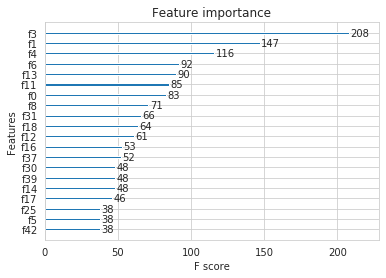

In [17]:
import xgboost as xgb
xgb.plot_importance(xgb_model_ddos, max_num_features=20)

In [18]:
# 3
X_pca[:10,3]

array([ 0.35759153,  0.05136076,  0.20415769,  0.04779349,  0.06005367,
        0.03970013,  0.03291846,  0.04145772, -0.00388655,  0.04392984])

In [19]:
# Fit model using each importance as a threshold
thresholds = np.sort(xgb_model_ddos.feature_importances_)
thresholds[:10]

array([0.00078076, 0.0010877 , 0.00109845, 0.00110977, 0.00136431,
       0.00154486, 0.00159432, 0.00160147, 0.00185064, 0.00208671],
      dtype=float32)

In [20]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(xgb_model_ddos, threshold=thresh, prefit=True)
    print(selection.get_support())
    # X_train(selection.get_support)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = xgb.XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.5f, n=%d, Accuracy: %.4f%%" %
          (thresh, select_X_train.shape[1], accuracy * 100.0))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
Thresh=0.00078, n=45, Accuracy: 99.5250%
[ True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
Thresh=0.00109, n=44, Accuracy: 99.5750%
[ True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True  True  True]
Thresh=0.00110, n=43, Accuracy: 99.6000%
[ True  True  True  True  True  True  True  True  Tr

Thresh=0.00360, n=19, Accuracy: 99.4250%
[ True  True  True  True  True False  True False False False False  True
 False  True  True False False False  True False False False False False
  True False False  True False False False  True False  True  True False
 False  True False False False False  True False  True]
Thresh=0.00365, n=18, Accuracy: 99.4500%
[ True  True  True  True  True False  True False False False False  True
 False  True  True False False False  True False False False False False
  True False False  True False False False  True False False  True False
 False  True False False False False  True False  True]
Thresh=0.00372, n=17, Accuracy: 99.4500%
[ True  True  True  True  True False  True False False False False  True
 False  True  True False False False  True False False False False False
  True False False  True False False False  True False False  True False
 False False False False False False  True False  True]
Thresh=0.00374, n=16, Accuracy: 99.4500%
[ True  Tru

##### 4. 去除重要性，比较

In [28]:
X_pca[0]

array([ 9.89452247e-01, -4.82675621e-01, -2.43201367e-01,  3.57591526e-01,
        1.41644223e-02,  6.12840290e-01, -2.62354935e-01,  6.55388902e-02,
       -1.13376729e-01, -1.20533229e-01, -1.00830164e-02, -6.47827060e-03,
       -3.80340298e-02,  9.78879698e-02, -1.44851204e-01,  8.85276139e-02,
        1.63364577e-01, -5.28317184e-02, -1.78599752e-02,  3.80277456e-02,
        4.56697174e-03, -5.09687593e-02,  1.64078586e-02,  3.29385820e-02,
        5.66689349e-03, -2.88941511e-02, -3.48653182e-04,  2.53975841e-03,
       -1.01383720e-02, -1.32587846e-02, -8.59865545e-03, -5.41281916e-03,
        2.73154409e-03, -1.02581045e-02,  1.68630905e-03, -4.24608011e-02,
        2.60740484e-02,  1.54279838e-02, -3.06321533e-02,  6.83095793e-04,
        7.50503597e-03,  1.69389341e-02, -1.22588099e-02,  2.86561956e-02,
        1.46361304e-02])

In [39]:
fi=xgb_model_ddos.feature_importances_
top_10=thresholds[-10:]
top_10

array([0.00629107, 0.00671652, 0.00750427, 0.00997738, 0.01207798,
       0.01386656, 0.01393139, 0.04492709, 0.32759264, 0.4607689 ],
      dtype=float32)

In [57]:
fi

array([0.00582108, 0.4607689 , 0.00750427, 0.04492709, 0.32759264,
       0.00231725, 0.00671652, 0.00261799, 0.00252689, 0.00078076,
       0.00208671, 0.01393139, 0.00293026, 0.01386656, 0.00582361,
       0.00287899, 0.002126  , 0.00211998, 0.00629107, 0.00160147,
       0.00210397, 0.00309391, 0.00280467, 0.00109845, 0.00374288,
       0.00270629, 0.00360446, 0.00997738, 0.00136431, 0.00110977,
       0.00216646, 0.01207798, 0.00332099, 0.00364698, 0.00548773,
       0.00225112, 0.00185064, 0.00372363, 0.0010877 , 0.00284685,
       0.00234686, 0.00154486, 0.00482495, 0.00159432, 0.00439334],
      dtype=float32)

In [75]:
sort_index=sorted(range(len(fi)), key=lambda k: fi[k],reverse=True)
print(sort_index)

[1, 4, 3, 11, 13, 31, 27, 2, 6, 18, 14, 0, 34, 42, 44, 24, 37, 33, 26, 32, 21, 12, 15, 39, 22, 25, 7, 8, 40, 5, 35, 30, 16, 17, 20, 10, 36, 19, 43, 41, 28, 29, 23, 38, 9]


In [102]:
def drop_top_n(X, indexs=sort_index, n=5):
    # change dataset
    X = X[:, indexs[n:]]
    # split train and test
    X_train, X_test, y_train, y_test = split_X_y(X, y)
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Drop top %d, Accuracy: %.4f%%" %
          (n, accuracy_score(y_test, y_pred) * 100.0))

In [105]:
for i in range(5, 40):
    drop_top_n(X_pca, n=i + 1)

Drop top 6, Accuracy: 99.4750%
Drop top 7, Accuracy: 99.4250%
Drop top 8, Accuracy: 99.5000%
Drop top 9, Accuracy: 99.4750%
Drop top 10, Accuracy: 99.5000%
Drop top 11, Accuracy: 99.4750%
Drop top 12, Accuracy: 99.1500%
Drop top 13, Accuracy: 99.2750%
Drop top 14, Accuracy: 99.2250%
Drop top 15, Accuracy: 99.2000%
Drop top 16, Accuracy: 99.1000%
Drop top 17, Accuracy: 99.1250%
Drop top 18, Accuracy: 99.2500%
Drop top 19, Accuracy: 99.1750%
Drop top 20, Accuracy: 99.3000%
Drop top 21, Accuracy: 99.3250%
Drop top 22, Accuracy: 99.0750%
Drop top 23, Accuracy: 99.0750%
Drop top 24, Accuracy: 99.2500%
Drop top 25, Accuracy: 99.0750%
Drop top 26, Accuracy: 99.0750%
Drop top 27, Accuracy: 99.0250%
Drop top 28, Accuracy: 98.7000%
Drop top 29, Accuracy: 98.6500%
Drop top 30, Accuracy: 98.6000%
Drop top 31, Accuracy: 98.4500%
Drop top 32, Accuracy: 98.3750%
Drop top 33, Accuracy: 98.0000%
Drop top 34, Accuracy: 97.9500%
Drop top 35, Accuracy: 97.6750%
Drop top 36, Accuracy: 96.7500%
Drop top 37,

可以看出，经过pca降维组合后的数据，当根据指标的重要性筛选出特征直到drop 30 以上 ，指标才会有些许变化，
接下来选取后10-15个 重要性比较低的特征做预测处理

##### 5. 新增派生特征

In [106]:
X_drop10=X_pca[:, sort_index[35:]]
X_drop10.shape

(19999, 10)

In [108]:
# 此时的分类矩阵为
X_drop10_train, X_drop10_test, _, _ = split_X_y(X_drop10, y)
# default
xgb_drop10_model = xgb.XGBClassifier(learning_rate=0.1,
                                     n_estimators=100,
                                     verbosity=1,
                                     silent=None,
                                     objective='binary:logistic',
                                     booster='gbtree',
                                     n_jobs=1,
                                     nthread=None,
                                     gamma=0,
                                     min_child_weight=1,
                                     max_delta_step=0,
                                     subsample=1,
                                     colsample_bytree=1,
                                     colsample_bylevel=1,
                                     colsample_bynode=1,
                                     reg_alpha=0,
                                     reg_lambda=1,
                                     scale_pos_weight=1,
                                     base_score=0.5,
                                     random_state=0,
                                     seed=None,
                                     missing=None)
xgb_drop10_model.fit(X_drop10_train, y_train)
y_drop10_pred = xgb_drop10_model.predict(X_drop10_test)
print(classify_re(y_test, y_drop10_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1992
           1       0.97      0.98      0.98      2008

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



In [109]:
# 简单调参增加n_estimators后就能提高 1-2个百分点
print(classify_re(y_test,xgb_model(X_drop10_train, y_train).predict(X_drop10_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1992
           1       0.99      0.99      0.99      2008

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



从原来的X的特征中加入port和Protocol 加入

In [112]:
ddos_data=get_orgrin_data(file)
ddos_data.head()

,Row,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,624,192.168.4.118-203.73.24.75-4504-80-6,192.168.4.118,4504,203.73.24.75,80,6,12/06/2010 08:34:32 AM,3974862,29,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
1,625,192.168.4.118-203.73.24.75-4504-80-6,192.168.4.118,4504,203.73.24.75,80,6,12/06/2010 08:34:36 AM,63,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
2,626,192.168.4.118-203.73.24.75-4505-80-6,192.168.4.118,4505,203.73.24.75,80,6,12/06/2010 08:34:36 AM,476078,2,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
3,627,192.168.4.118-203.73.24.75-4505-80-6,192.168.4.118,4505,203.73.24.75,80,6,12/06/2010 08:34:37 AM,151,2,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
4,628,192.168.4.118-203.73.24.75-4506-80-6,192.168.4.118,4506,203.73.24.75,80,6,12/06/2010 08:34:37 AM,472507,2,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos


In [115]:
add_data=ddos_data[["Dst Port", "Protocol"]]
add_data

,Dst Port,Protocol
0,80,6
1,80,6
2,80,6
3,80,6
4,80,6
...,...,...
19994,53598,6
19995,443,6
19996,53,17
19997,53,17


In [128]:
add_data=add_data.to_numpy()
add_data

array([[80,  6],
       [80,  6],
       [80,  6],
       ...,
       [53, 17],
       [53, 17],
       [80,  6]])

In [130]:
X_new=X_drop10.copy()
X_new

array([[-0.01008302,  0.02607405,  0.03802775, ...,  0.03293858,
        -0.03063215, -0.12053323],
       [-0.01265683,  0.00546485, -0.00910855, ..., -0.00150017,
        -0.00604926,  0.0807285 ],
       [ 0.02981446, -0.01660042, -0.04627342, ...,  0.00695498,
         0.00064571,  0.09681004],
       ...,
       [ 0.02976141,  0.00062601,  0.00450694, ..., -0.0071257 ,
         0.00242935, -0.07492116],
       [ 0.03051314,  0.00238083,  0.00733136, ..., -0.00738904,
         0.00220599, -0.07669363],
       [-0.04330109,  0.00970069,  0.01424877, ..., -0.03900038,
         0.00025837,  0.07025459]])

In [133]:
X_new_data = np.concatenate((X_new, add_data), axis=1)
X_new_data.shape

(19999, 12)

In [134]:
# 使用之前的模型+ 新的标签 ，准确率上升 2-3个百分点，已接近1
# 此时的分类矩阵为
X_new_train, X_new_test, _, _ = split_X_y(X_new_data, y)
print(
    classify_re(y_test,
                xgb_drop10_model.fit(X_new_train,
                                     y_train).predict(X_new_test)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1992
           1       0.99      1.00      0.99      2008

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



##### 6. 算法改进，比较

Xgboost不是一种算法，而是封装了GBDT的模型框架。微软实现的的Lightgbm是更优的框架
###### 优化点
1 系统优化

- 并行：XGBoost 用并行的方式实现了序列树的构建过程。考虑到用于构建基础学习器的循环、枚举树的叶节点的外部循环以及计算特征的第二个内部循环的可互换性，这是完全有可能实现的。由于没有完整的内部循环就无法启动外部循环（两个循环要求的计算资源更多），因此这种嵌套的循环限制了并行。为了改善运行时，就要交换循环的顺序，这通过对所有实例进行全局扫描来执行初始化以及用并行线程排序来实现。这样的变换抵消了计算中并行所需的开销，从而提升了算法性能。
- 剪枝：从本质上讲 GBM 框架内树分裂的停止标准是贪婪的，这取决于分裂点的负损失。XGBoost 优先使用指定的「max_depth」参数，然后开始后向修剪树。这种「深度优先」的方法显著提升了计算性能。
- 硬件优化：XGBoost 算法可以有效利用硬件资源。这是通过缓存感知（cache awareness）实现的，而缓存感知则是通过在每个线程中分配内部缓冲区来存储梯度统计信息实现的。「核外」计算等进一步增强措施则在处理与内存不兼容的大数据帧时优化了可用磁盘空间。

2 算法增强：

- 正则化：用 LASSO（L1）正则化和 Ridge（L2）正则化惩罚更复杂的模型，以防止过拟合。
- 稀疏性感知（Sparsity Awareness）：XGBoost 根据训练损失自动「学习」最佳缺失值，从而承认输入的稀疏特征，还可以更高效地处理数据中不同类型的稀疏模式。
- 加权分位数略图（Weighted Quantile Sketch）：XGBoost 用分布式加权分位数略图算法（https://arxiv.org/pdf/1603.02754.pdf）高效地从加权数据集中找到最佳分裂点。
- 交叉验证：该算法在每次迭代时都使用内置的交叉验证方法，这样就无需特地为搜索编程，也不需要每次运行时都指定所需迭代增强的确切数目

In [ ]:
手动实现，xgboost是多个算法的结合，实现和改进都比较复杂，作参考
可改进其他算法

In [ ]:
https://zhuanlan.zhihu.com/p/32181687

In [ ]:
class LeastSquaresLoss():
    """Least squares loss"""

    def gradient(self, actual, predicted):
        return actual - predicted

    def hess(self, actual, predicted):
        return np.ones_like(actual)

In [ ]:
class XGBoostRegressionTree(DecisionTree):
    """
    Regression tree for XGBoost
    - Reference -
    http://xgboost.readthedocs.io/en/latest/model.html
    """
    def _split(self, y):
        """ y contains y_true in left half of the middle column and
        y_pred in the right half. Split and return the two matrices """

        col = int(np.shape(y)[1] / 2)
        y, y_pred = y[:, :col], y[:, col:]
        return y, y_pred

    def _gain(self, y, y_pred):
        nominator = np.power((self.loss.gradient(y, y_pred)).sum(), 2)
        denominator = self.loss.hess(y, y_pred).sum()
        return 0.5 * (nominator / denominator)

    def _gain_by_taylor(self, y, y1, y2):
        # Split
        y, y_pred = self._split(y)
        y1, y1_pred = self._split(y1)
        y2, y2_pred = self._split(y2)

        true_gain = self._gain(y1, y1_pred)
        false_gain = self._gain(y2, y2_pred)
        gain = self._gain(y, y_pred)
        return true_gain + false_gain - gain

    def _approximate_update(self, y):
        # y split into y, y_pred
        y, y_pred = self._split(y)
        gradient = np.sum(self.loss.gradient(y, y_pred), axis=0)
        hessian = np.sum(self.loss.hess(y, y_pred), axis=0)
        update_approximation = gradient / hessian
        return update_approximation

    def fit(self, X, y):
        self._impurity_calculation = self._gain_by_taylor
        self._leaf_value_calculation = self._approximate_update
        super(XGBoostRegressionTree, self).fit(X, y)

In [ ]:
class XGBoost(object):
    """The XGBoost classifier.
 
    Reference: http://xgboost.readthedocs.io/en/latest/model.html
 
    n_estimators: int
    树的数量
    The number of classification trees that are used.
learning_rate: float
    梯度下降的学习率
    The step length that will be taken when following the negative gradient during
    training.
min_samples_split: int
    每棵子树的节点的最小数目（小于后不继续切割）
    The minimum number of samples needed to make a split when building a tree.
min_impurity: float
    每颗子树的最小纯度（小于后不继续切割）
    The minimum impurity required to split the tree further.
max_depth: int
    每颗子树的最大层数（大于后不继续切割）
    """
    def __init__(self,
                 n_estimators=200,
                 learning_rate=0.01,
                 min_samples_split=2,
                 min_impurity=1e-7,
                 max_depth=2):
        self.n_estimators = n_estimators  # Number of trees
        self.learning_rate = learning_rate  # Step size for weight update
        self.min_samples_split = min_samples_split  # The minimum n of sampels to justify split
        self.min_impurity = min_impurity  # Minimum variance reduction to continue
        self.max_depth = max_depth  # Maximum depth for tree

        self.bar = progressbar.ProgressBar(widgets=bar_widgets)

        # Log loss for classification
        self.loss = LeastSquaresLoss()

        # Initialize regression trees
        self.trees = []
        for _ in range(n_estimators):
            tree = XGBoostRegressionTree(
                min_samples_split=self.min_samples_split,
                min_impurity=min_impurity,
                max_depth=self.max_depth,
                loss=self.loss)

            self.trees.append(tree)

    def fit(self, X, y):
        # y = to_categorical(y)
        m = X.shape[0]
        y = np.reshape(y, (m, -1))
        y_pred = np.zeros(np.shape(y))
        for i in self.bar(range(self.n_estimators)):
            tree = self.trees[i]
            y_and_pred = np.concatenate((y, y_pred), axis=1)
            tree.fit(X, y_and_pred)
            update_pred = tree.predict(X)
            update_pred = np.reshape(update_pred, (m, -1))
            y_pred += update_pred

    def predict(self, X):
        y_pred = None
        m = X.shape[0]
        # Make predictions
        for tree in self.trees:
            # Estimate gradient and update prediction
            update_pred = tree.predict(X)
            update_pred = np.reshape(update_pred, (m, -1))
            if y_pred is None:
                y_pred = np.zeros_like(update_pred)
            y_pred += update_pred

        return y_pred